In [3]:
import os
import torch
import math
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import json
import cv2
import re
import random
import torchvision.transforms as transforms
from torchvision.io import read_image

import matplotlib.pyplot as plt
import torchvision.transforms as T


class PanopticDataset(Dataset):
    def __init__(self, transform, data_set='training'):

        # change this to the path where the dataset is stored
        self.data_path = "ProcessedPanopticDataset\\"
        self.training_dir = []

        self.transform = transform

        self.set = data_set

        paths = []

        motion_seq = os.listdir(self.data_path)
        no_dir = ['scripts','python','matlab','.git','glViewer.py','README.md','matlab',
                'README_kinoptic.md', '171204_pose3']

        for dir in motion_seq:
            if dir not in no_dir:
                if 'haggling' in dir:
                    continue
                elif dir == '171204_pose2' or dir =='171204_pose5' or dir =='171026_cello3':
                    if os.path.exists(os.path.join(self.data_path,dir, 'hdJoints')):
                        data_path = os.path.join(self.data_path,dir, 'hdJoints')
                        for lists in (os.listdir(data_path)):
                            paths.append(os.path.join(data_path,lists.split('.json')[0]))
                elif 'ian' in dir:
                    continue
                else:
                    if os.path.exists(os.path.join(self.data_path,dir,'hdJoints')):
                        data_path = os.path.join(self.data_path,dir,'hdJoints')
                        for lists in (os.listdir(data_path)):
                            paths.append(os.path.join(data_path,lists.split('.json')[0]))

        self.data = {'paths': paths}

    def __len__(self):
        return len(self.data['paths'])

    def get_second_view(self, image_path):
        """Randomly gets another camera view"""
        split = image_path.split(';')
        camera = split[1].split('_')
        view = int(camera[-1]) # id of the first view

        second_view = random.randint(0, view) if view > 15 else random.randint(view + 1, 30) # randomly get second view id that is smaller or bigger than the first one

        camera[2] = str(second_view) if second_view > 9 else '0' + str(second_view)
        camera = '_'.join(camera)
        split[1] = camera
        second_path = ';'.join(split)

        return second_path


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = dict()

        path_split = self.data['paths'][idx].split('\\hdJoints')
        image1_path = path_split[0] + '\\hdImages' + path_split[-1] + '.jpg'
        image2_path = self.get_second_view(image1_path)

        for i in range(0, 10):
            if os.path.isfile(image2_path):
                image2 = cv2.imread(image2_path)
                image2 =cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
                image2 = self.transform(image2)
                break
            else:
                image2_path = self.get_second_view(image1_path)
        else:
            # apply random rotation on the first image if the second view cannot be found in 10 iterations
            image2 = cv2.imread(image1_path)
            image2 =cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
            image2 = self.transform(image2)
            image2 = T.RandomRotation(45)(image2)

        image1 = cv2.imread(image1_path)
        image1 =cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        image1 = self.transform(image1)

        sample['image1'] = image1
        sample['image2'] = image2

        return sample

In [4]:
def get_dataset(batch_size):
    transforms = T.Compose(
        [
            T.ToTensor(),
            T.Resize(size=(128, 128)),
        ]
    )

    dataset = PanopticDataset(transforms)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size)

    return dataset, train_loader

In [5]:
def plot_item(data, ind):
    el = data[ind]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 10))
    ax1.imshow(el['image1'].permute(1, 2, 0))
    ax2.imshow(el['image2'].permute(1, 2, 0))

    plt.show()

In [6]:
data, loader = get_dataset(443)
plot_item(data, 202)

c:\Users\david\Documents\PROGETTI\SIV\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# SimCLR method

### Similar to [SimCLR](https://arxiv.org/pdf/2002.05709.pdf) I take the base encoder model (ResNet50) and replace its fully connected layer with a projection head.

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return x, self.layers(x)

In [8]:
from torchvision.models import resnet50, ResNet50_Weights


def get_simclr_net():
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    model.fc = MLP(2048, 2048, 128)

    return model

### I use LARS as an optimizer because SimCLR method works particularly well on large batches where SGD would not work well.

In [9]:
# uncomment this if you get an No module named 'pytorch_lightning.utilities.apply_func' error
# !pip3 install pytorch-lightning==1.2.2

In [10]:
from flash.core.optimizers import LARS


def get_optimizer(model, lr, wd, momentum):
    final_layer_weights = []
    rest_of_the_net_weights = []

    for name, param in model.named_parameters():
        if name.startswith('fc'):
            final_layer_weights.append(param)
        else:
            rest_of_the_net_weights.append(param)

    optimizer = LARS([
        {'params': rest_of_the_net_weights},
        {'params': final_layer_weights, 'lr': lr}
    ], lr=lr / 2, weight_decay=wd, momentum=momentum)

    return optimizer


ModuleNotFoundError: No module named 'flash.core'

### Implementation of NT-Xent loss (the normalized temperature-scaled cross entropy loss)

In [ ]:
import torch.nn.functional as F


def get_loss(geom_encoddings, app_encoddings, t):
    geom_encoddings = F.normalize(geom_encoddings, p=2, dim=1)
    app_encoddings = F.normalize(app_encoddings, p=2, dim=1)

    def get_sim(zi, zj, t):
        cosi = torch.nn.CosineSimilarity(dim=1)
        return torch.exp(cosi(zi, zj) / t)

    num = get_sim(geom_encoddings, app_encoddings, t)
    num = torch.cat([num, num])

    batch = torch.cat([geom_encoddings, app_encoddings])
    batch = batch / batch.norm(dim=1)[:, None]
    sim = torch.mm(batch, batch.transpose(0,1))
    sim = torch.exp(sim / t)

    denom = torch.sum(sim, dim=1) - torch.diagonal(sim, 0)
    loss_vec = - torch.log(num / denom)

    loss = loss_vec.sum() / batch.size()[0]

    return loss


In [ ]:
from tqdm import tqdm


def train_step(net, data_loader, optimizer, cost_function, t, device='cuda'):
    samples = 0.
    cumulative_loss = 0.
    net.train()

    for batch_idx, batch in enumerate(tqdm(data_loader)):

        image1 = batch['image1'].to(device)
        image2 = batch['image2'].to(device)

        _, image1_encoddings = net(image1)
        _, image2_encoddings = net(image2)

        loss = cost_function(image1_encoddings, image2_encoddings, t)
        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

        cumulative_loss += loss.item()
        samples += image1.shape[0]

    return cumulative_loss / samples


In [ ]:
def main(batch_size=1024, device='cuda:0', learning_rate=0.01, weight_decay=0.000001, momentum=0.9, t=0.6, epochs=10):
    _, train_loader = get_dataset(batch_size)

    net = get_simclr_net()
    net.to(device)

    optimizer = get_optimizer(net, lr=learning_rate, wd=weight_decay, momentum=momentum)

    cost_function = get_loss

    for e in range(epochs):
        train_loss = train_step(net, train_loader, optimizer, cost_function, t, device)

        print('Epoch: {:d}'.format(e+1))
        print('\tTraining loss {:.5f}'.format(train_loss))

    torch.save(net.state_dict(), 'ver0.pt')


### Due to the memory constraint, I use batch size of 200, however, larger batch size is preferred. The training was done on 20 epochs.

In [ ]:
main(batch_size=200, epochs=20)

# Clustering

For clustering I use the dataset of 6000 images that contains different poses. I extract the representations from the trained model and run K means clustering algorithm (number of clusters=8) on these representation. I reduce the dimentionality of the representations with PCA algorithm and plot the clustering. For the comparison I use the representations extracted from encoder model (before the projection head) and the representations extracted after the projection head.

In [ ]:
class ClusterDataset(Dataset):
    def __init__(self, transform, data_set='training'):

        # change this to the path where the dataset is stored
        self.data_path = "../../dataset/Panoptic/ProcessedPanopticDataset/171204_pose3/hdImages"

        images = [os.path.join(self.data_path, f) for f in os.listdir(self.data_path) if os.path.isfile(os.path.join(self.data_path, f))][0:6000]
        self.transform = transform

        self.data = {'paths': images}


    def __len__(self):
        return len(self.data['paths'])


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = dict()

        image_path = self.data['paths'][idx]

        image = cv2.imread(image_path)
        image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)

        sample['image'] = image

        return sample

In [ ]:
def get_cluster_data(batch_size):
    transforms = T.Compose(
        [
            T.ToTensor(),
            T.Resize(size=(128, 128)),
        ]
    )

    cluster_dataset = ClusterDataset(transforms)
    cluster_loader = torch.utils.data.DataLoader(cluster_dataset, batch_size)

    return cluster_dataset, cluster_loader

In [ ]:
def extract_representations(path, cluster_loader, load=True):
    net = get_simclr_net()

    if load:
        net.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

    net.to('cpu')
    net.eval()

    proj_repr = []
    base_repr = []

    with torch.no_grad():
        for batch_idx, inputs in enumerate(cluster_loader):
            images = inputs['image']
            images.to('cpu')
            base, proj = net(images)
            proj_repr.append(proj)
            base_repr.append(base)

    return torch.cat(base_repr).numpy(), torch.cat(proj_repr).numpy()

In [ ]:
from sklearn.cluster import KMeans


def kmeans_algorithm(features, n_clusters=8):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(features)

    return kmeans.labels_

In [ ]:
from sklearn.decomposition import PCA


def reduce_dim(features):
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)

    return pca_features

In [ ]:
def plot_clusters(clusters, pca_features, title):
    colors = {
        0: '#F8512E', 1: '#F8F82E',
        2: '#40F82E', 3: '#2EC1F8',
        4: '#6B2EF8', 5: '#D92EF8',
        6: '#731642', 7: '#092040'
    }

    cluster_colors = [colors[c] for c in clusters]

    plt.scatter(pca_features[:, 0], pca_features[:, 1], color=cluster_colors)
    plt.title(title)
    plt.show()

In [ ]:
from sklearn.metrics import silhouette_score


def cluster(model_path, load=True):
    cluster_set, cluster_loader = get_cluster_data(30)

    base_features, proj_features = extract_representations(model_path, cluster_loader, load)

    labels_base = kmeans_algorithm(base_features)
    pca_base = reduce_dim(base_features)

    labels_proj = kmeans_algorithm(proj_features)
    pca_proj = reduce_dim(proj_features)

    silhouette_base = silhouette_score(base_features, labels_base)
    silhouette_proj = silhouette_score(proj_features, labels_proj)

    print("Silhouette score for the encoder features: {}".format(silhouette_base))
    print("Silhouette score for the projection head features: {}".format(silhouette_proj))

    plot_clusters(labels_base, pca_base, "Encoder features")
    plot_clusters(labels_proj, pca_proj, "Projection head features")

    return cluster_set, base_features, proj_features, labels_base, labels_proj, pca_base, pca_proj

## PCA visualization based on the model preprained with 0.005 learning rate for base encoder

/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for the encoder features: 0.45356929302215576


/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for the projection head features: 0.5311034321784973


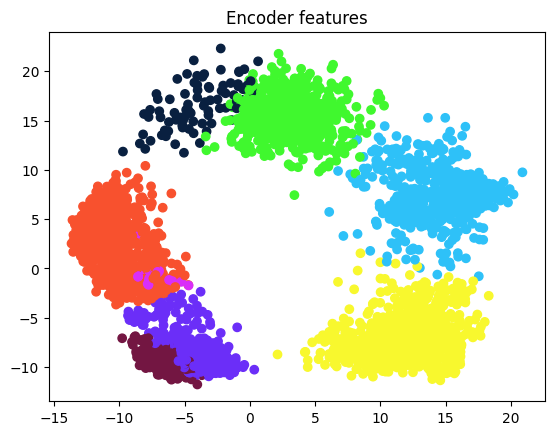

In [ ]:
path = '../trained_models/ver1.pt'

cluster_set, base_features, proj_features, labels_base, labels_proj, pca_base, pca_proj = cluster(path)

## PCA visualization based on the model preprained with 0.0001 learning rate for base encoder

/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/olha/unitn/

Silhouette score for the encoder features: 0.18690647184848785
Silhouette score for the projection head features: 0.4149715304374695


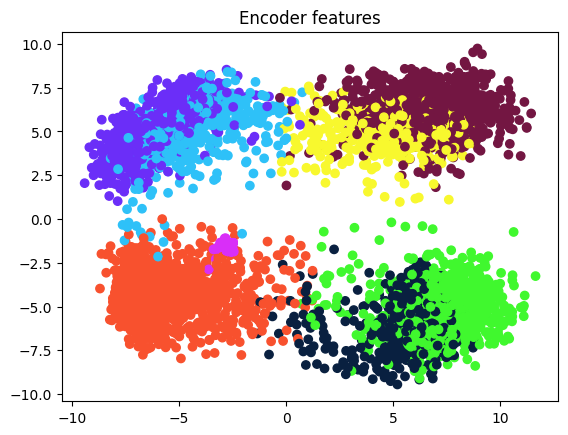

In [ ]:
path = '../trained_models/ver0.pt'

cluster_set, base_features, proj_features, labels_base, labels_proj, pca_base, pca_proj = cluster(path)

## PCA visualization before training

In [ ]:
_, _, _, _, _, _, _ = cluster(path, False)

/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/olha/unitn/NLU/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/olha/unitn/

Silhouette score for the encoder features: 0.10401729494333267
Silhouette score for the projection head features: 0.09785526245832443


## Clustering results

In [ ]:
def plot_one_cluster(dataset, cluster_ind, labels):
    indexes = [i for i in range(0, len(labels)) if labels[i]==cluster_ind]

    plt.figure(figsize = (10,10))

    for i in range(0, 9):
        ax = plt.subplot(3, 3, i+1)
        ax.imshow(dataset[indexes[random.randint(0, len(indexes)-1)]]['image'].permute(1, 2, 0))

    plt.show()

## Clustering based on features extracted from base encoder

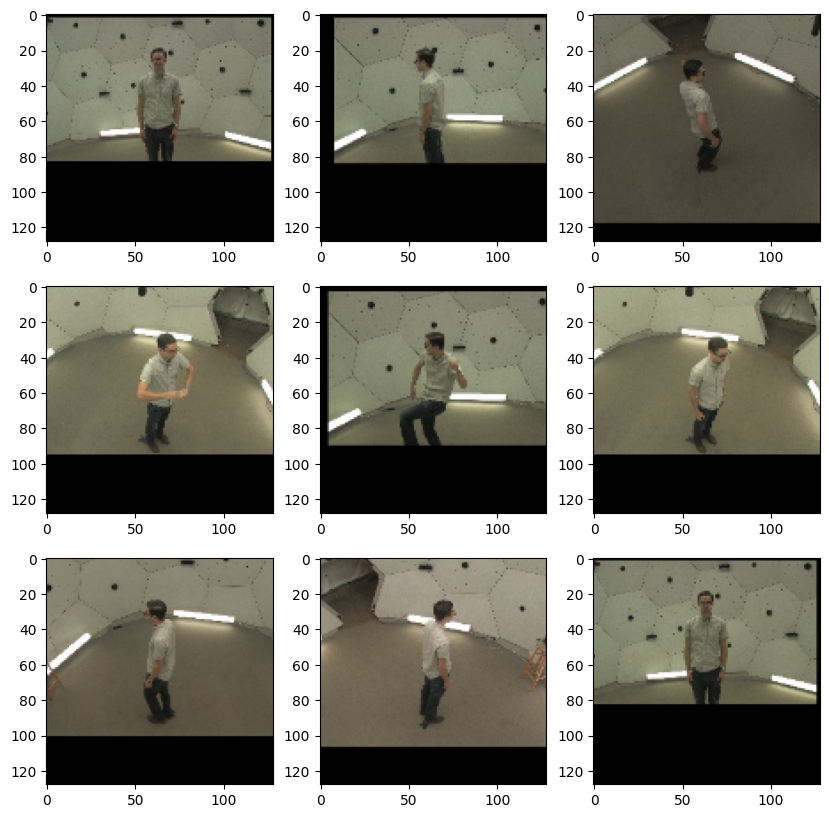

In [ ]:
plot_one_cluster(cluster_set, 0, labels_base)

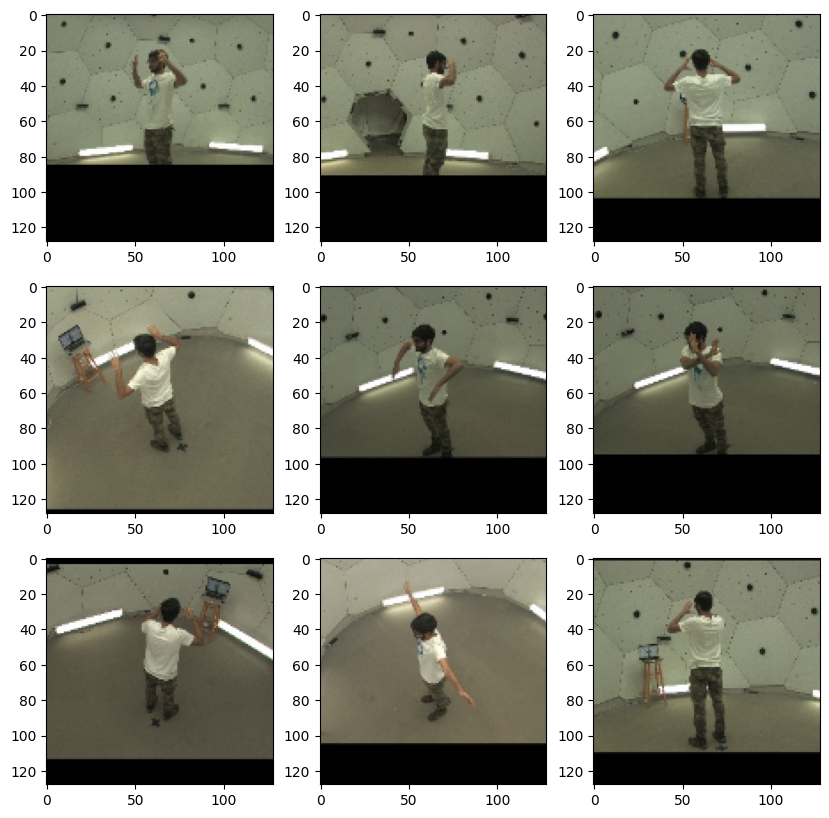

In [ ]:
plot_one_cluster(cluster_set, 1, labels_base)

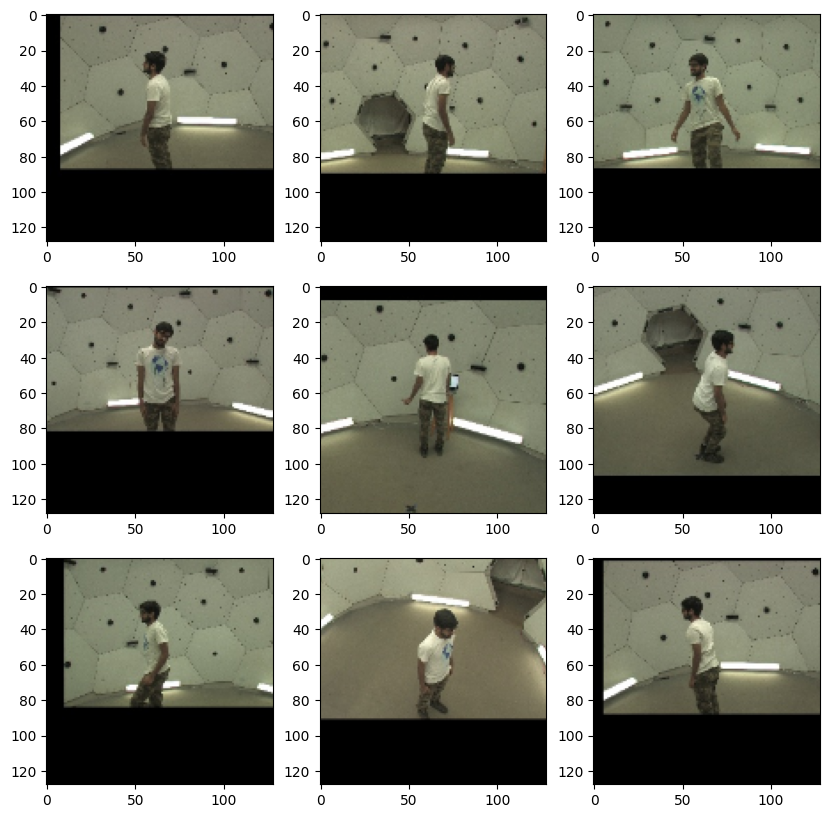

In [ ]:
plot_one_cluster(cluster_set, 2, labels_base)

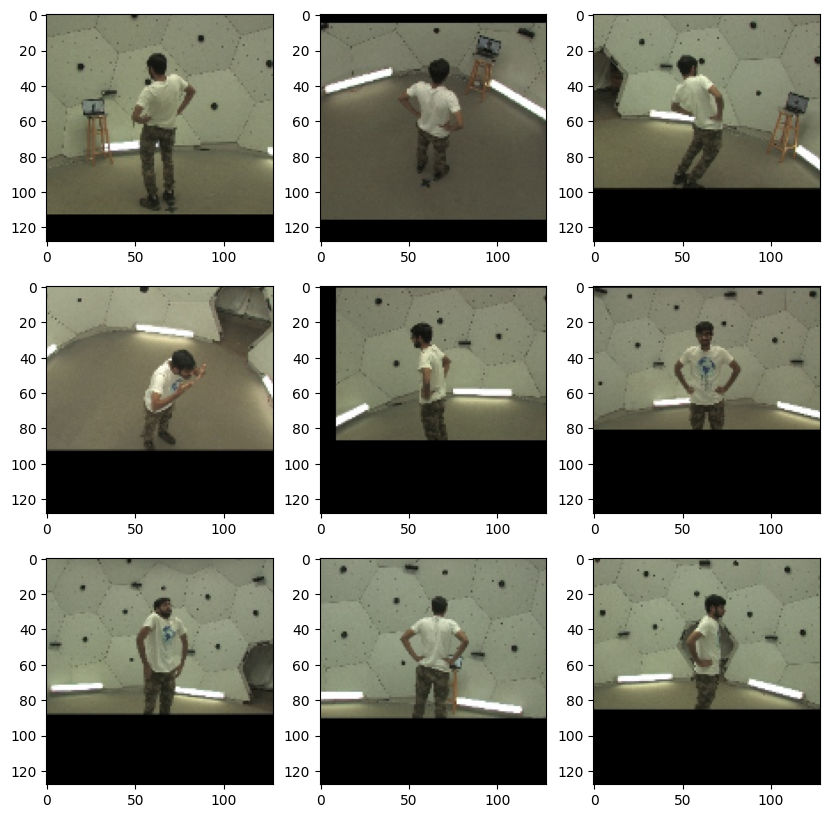

In [ ]:
plot_one_cluster(cluster_set, 3, labels_base)

In [ ]:
plot_one_cluster(cluster_set, 4, labels_base)

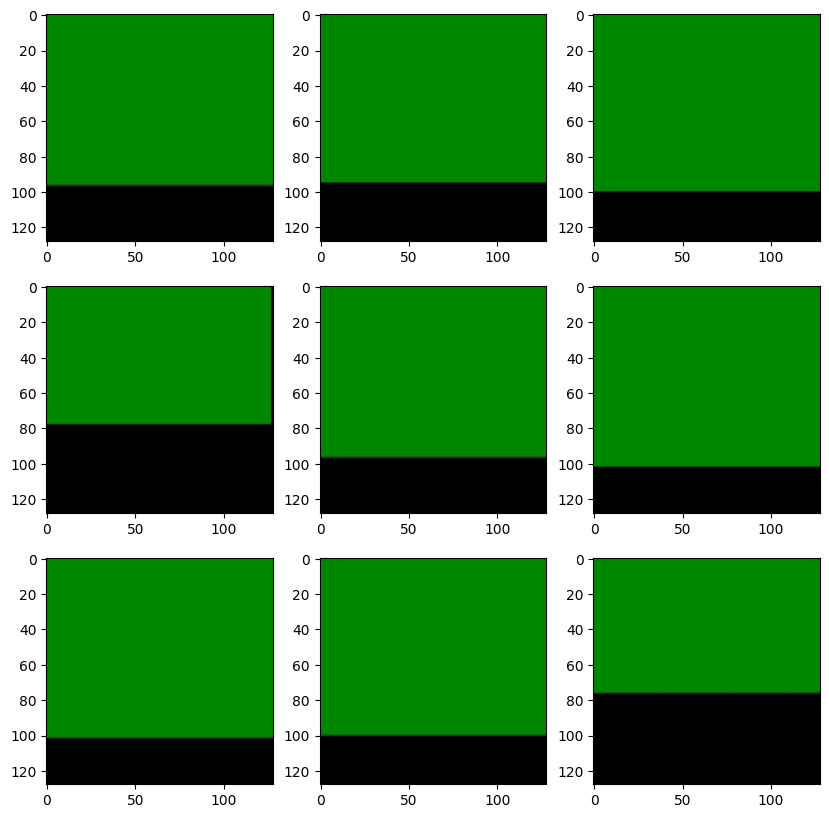

In [ ]:
plot_one_cluster(cluster_set, 5, labels_base)

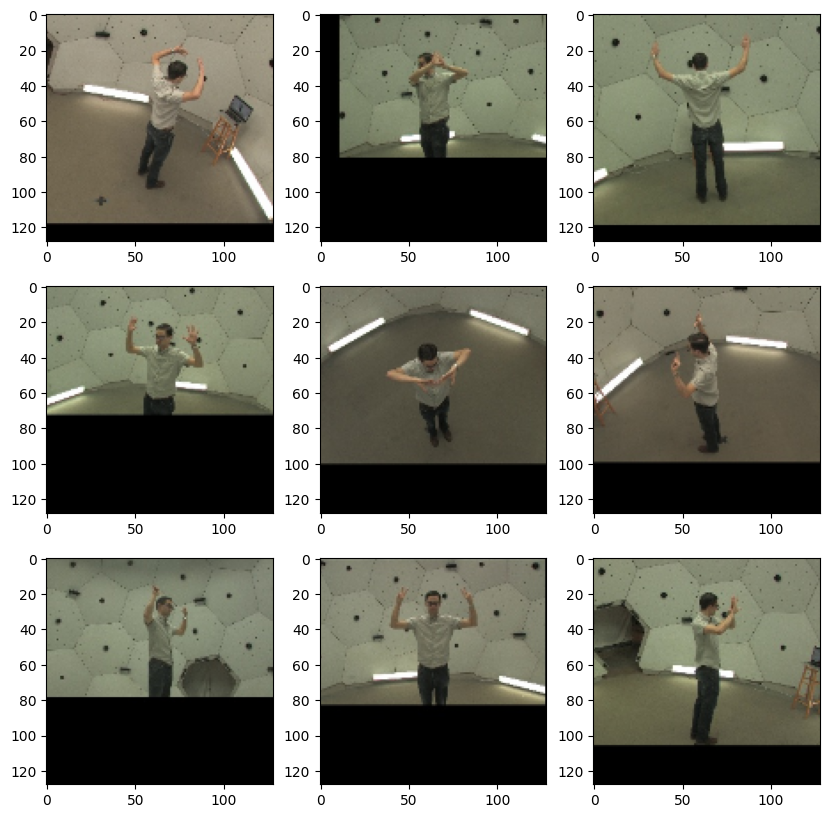

In [ ]:
plot_one_cluster(cluster_set, 6, labels_base)

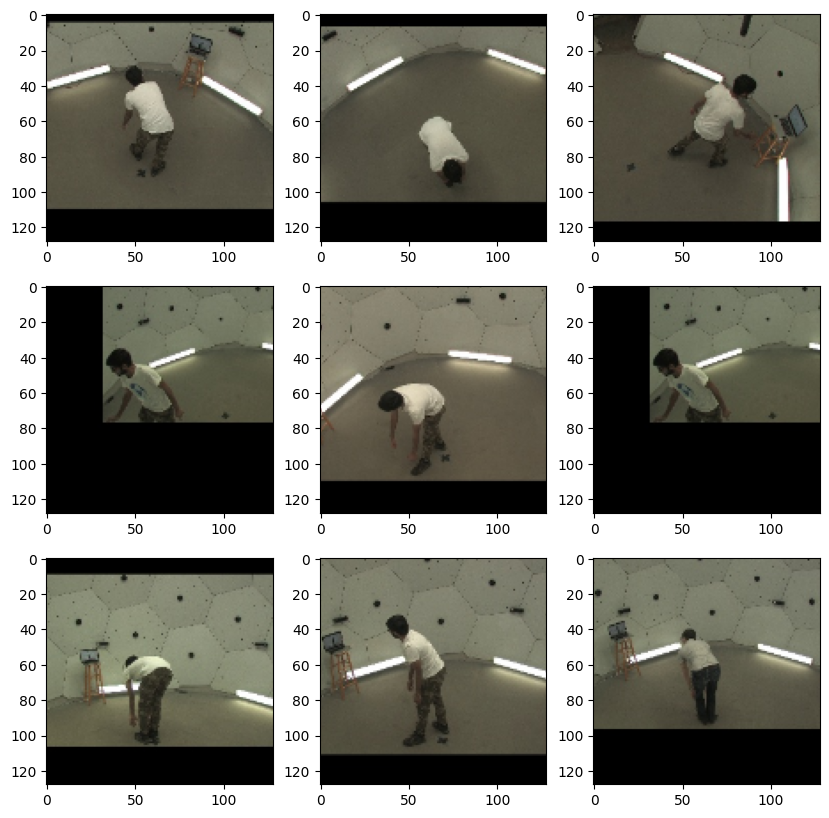

In [ ]:
plot_one_cluster(cluster_set, 7, labels_base)

## Clustering based on features extracted from projection head

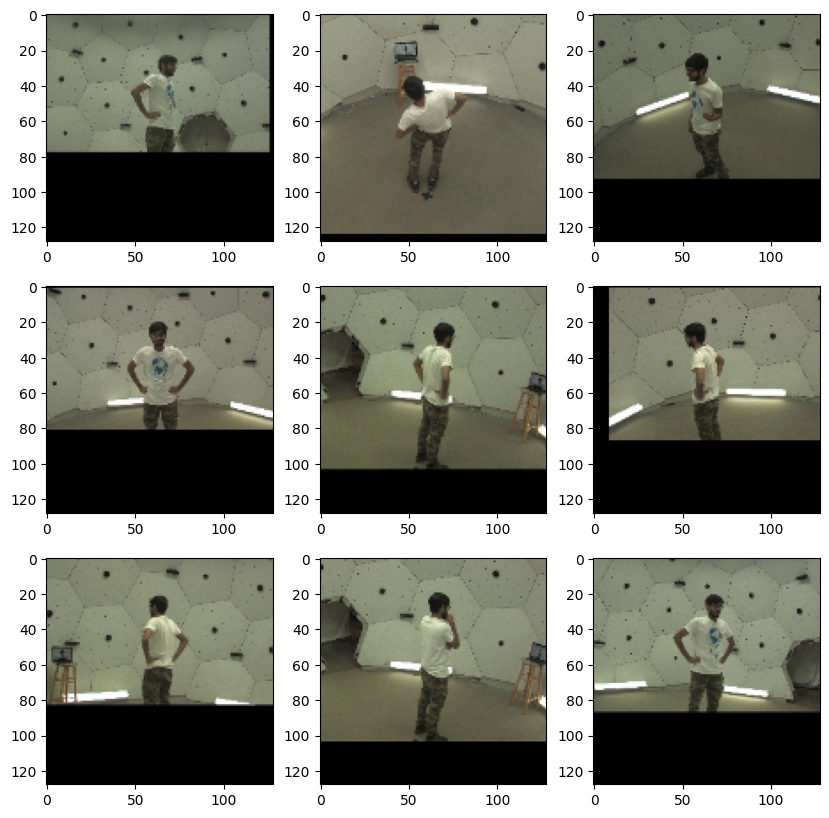

In [ ]:
plot_one_cluster(cluster_set, 0, labels_proj)

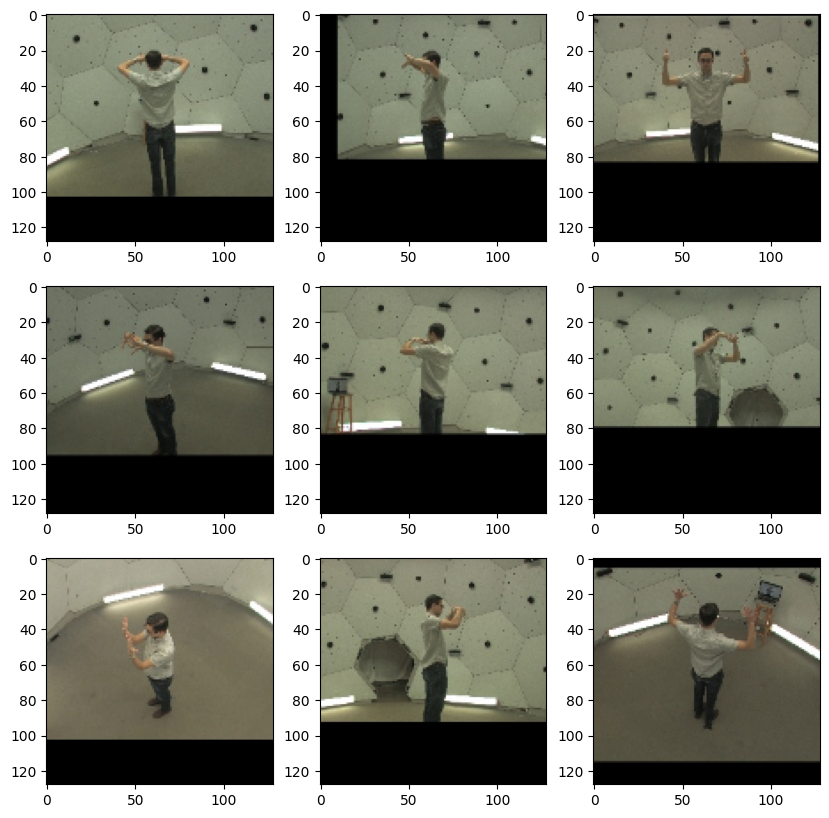

In [ ]:
plot_one_cluster(cluster_set, 1, labels_proj)

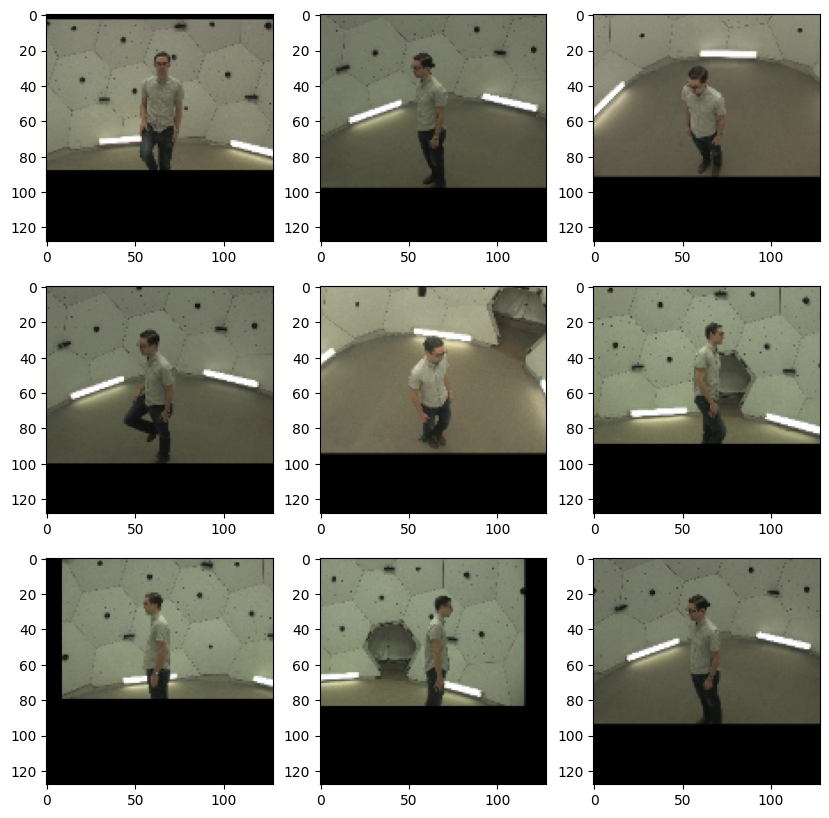

In [ ]:
plot_one_cluster(cluster_set, 2, labels_proj)

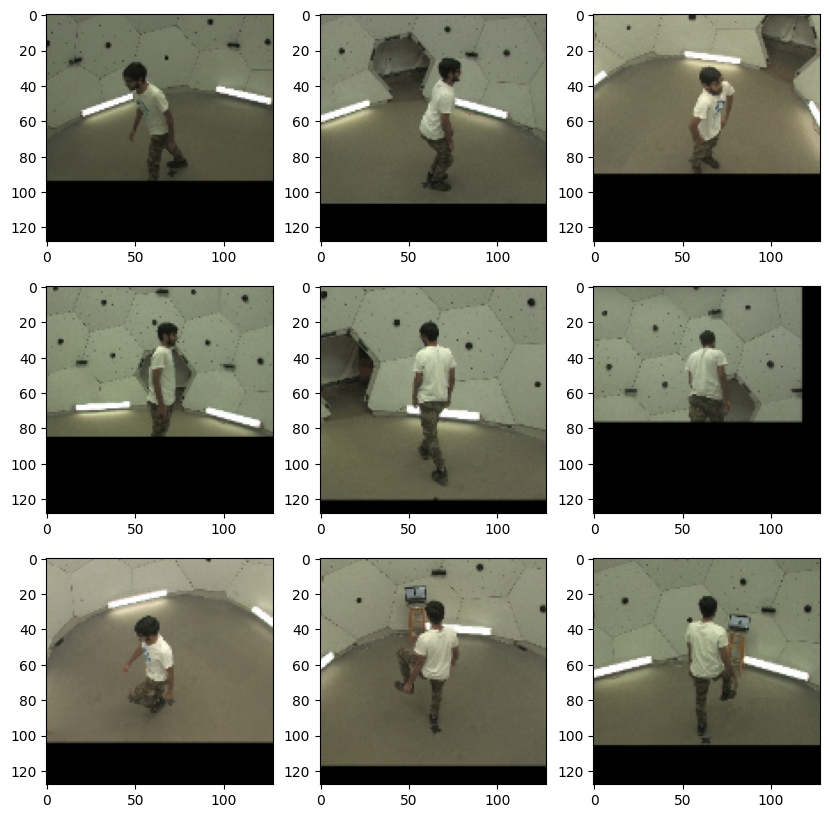

In [ ]:
plot_one_cluster(cluster_set, 3, labels_proj)

In [ ]:
plot_one_cluster(cluster_set, 4, labels_proj)

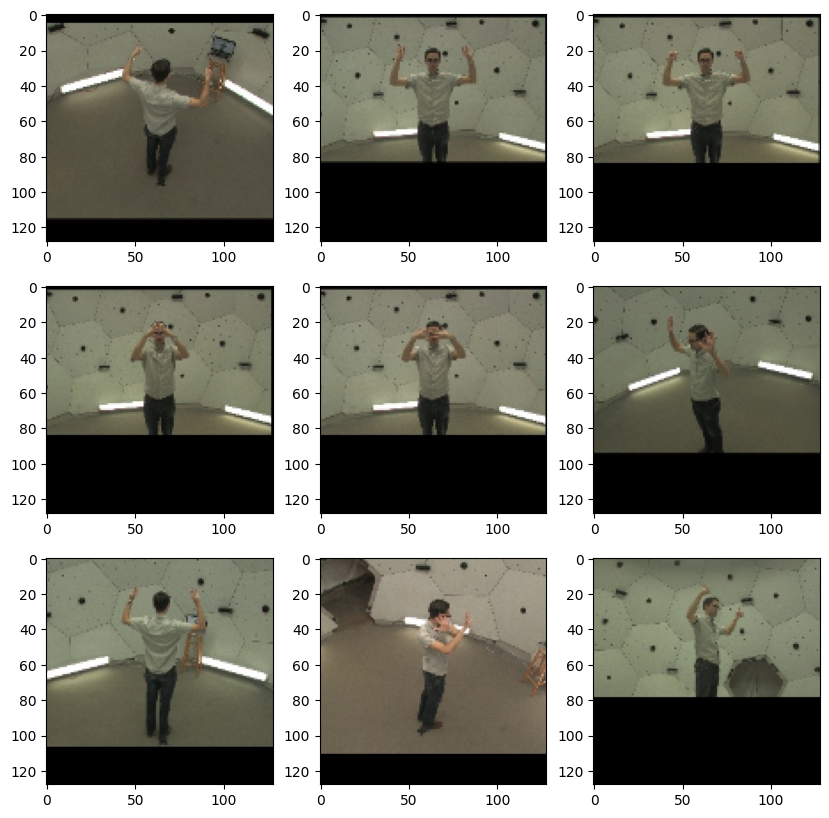

In [ ]:
plot_one_cluster(cluster_set, 5, labels_proj)

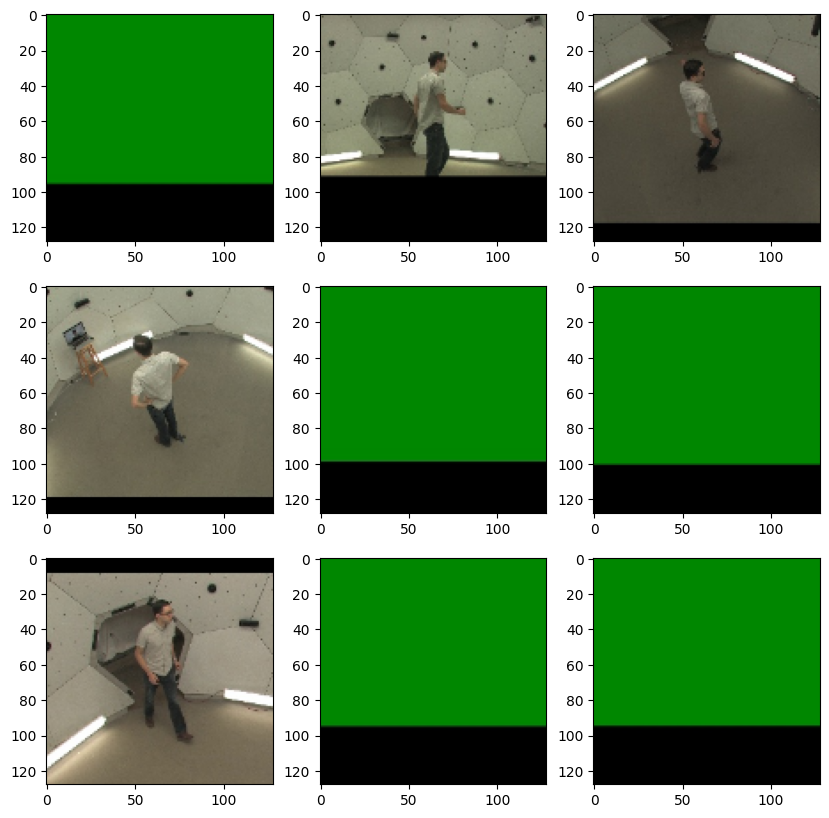

In [ ]:
plot_one_cluster(cluster_set, 6, labels_proj)

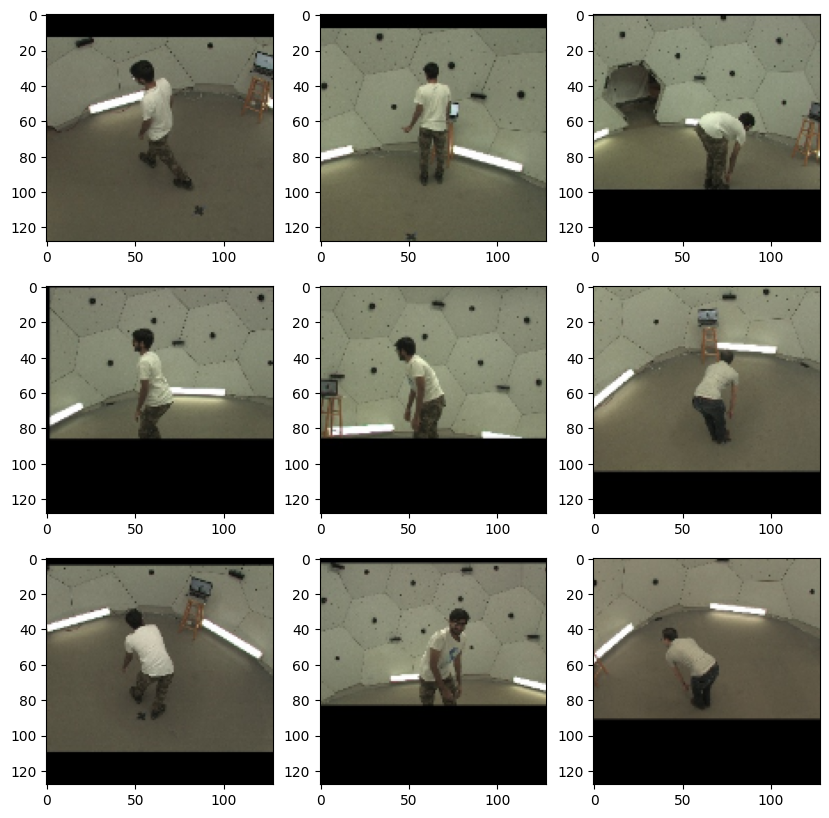

In [ ]:
plot_one_cluster(cluster_set, 7, labels_proj)